# Polystyrene Mastercurve Analysis

Sweep GM modes on polystyrene mastercurve.

**Data:** examples/data/mastercurves/master_curve_ps_oscillation_data.csv

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


## Load polystyrene mastercurve

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'mastercurves'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Sweep GM modes

In [4]:
records = []
for modes in [2, 4, 6, 8]:
    model = GeneralizedMaxwell(n_modes=modes, modulus_type='tensile')
    model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    pred = model.predict(omega)
    if pred.ndim == 2:
        pred = pred[:,0] + 1j*pred[:,1]
    r2 = r2_complex(G_star, pred)
    records.append({'n_modes': modes, 'r2': r2})
pd.DataFrame(records)


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.065417s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=9.7350e+11 | elapsed=2.065s | final_gradient_norm=6.9265e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.722009s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=9.7350e+11 | elapsed=0.722s | final_gradient_norm=6.9265e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.613984s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=3.6883e+12 | elapsed=1.614s | final_gradient_norm=6.2810e+19


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.960136s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.0574e+11 | elapsed=3.960s | final_gradient_norm=6.7697e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.420097s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.0574e+11 | elapsed=1.420s | final_gradient_norm=6.7697e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.655684s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=73 | final_cost=3.5477e+11 | elapsed=2.656s | final_gradient_norm=3.0624e+18


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.381233s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=3.381s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.331554s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=1.332s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.771223s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=36 | final_cost=3.9375e+10 | elapsed=1.771s | final_gradient_norm=1.7507e+17


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.329769s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=2.330s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.145345s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=1.145s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.311271s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.4249e+10 | elapsed=2.311s | final_gradient_norm=5.1213e+21


,n_modes,r2
0,2,0.982704
1,4,0.998121
2,6,0.999666
3,8,0.999800


## Plot best vs data

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.332778s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=1.333s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.180353s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=1.180s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.763921s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.4249e+10 | elapsed=0.764s | final_gradient_norm=5.1213e+21


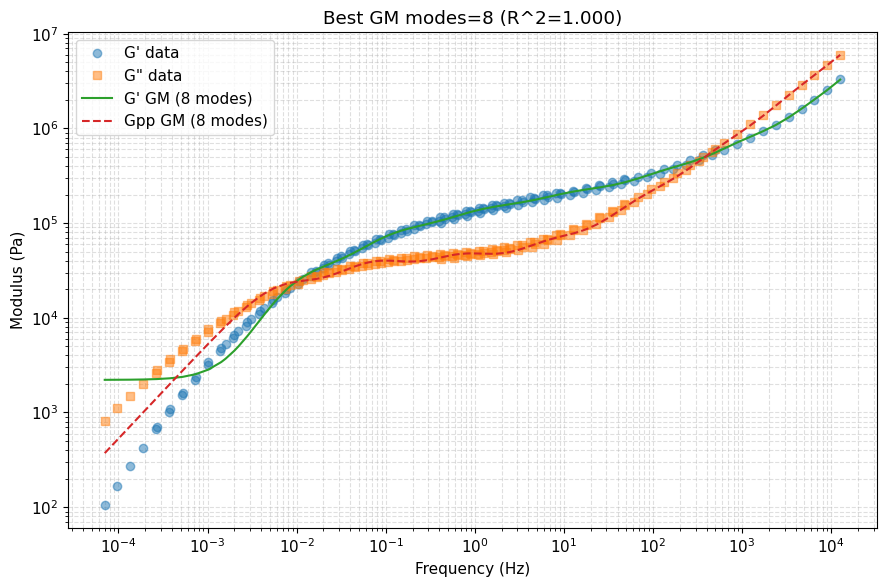

In [5]:
best = max(records, key=lambda x: x['r2'])
best_model = GeneralizedMaxwell(n_modes=best['n_modes'], modulus_type='tensile')
best_model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
best_pred = best_model.predict(omega)
if best_pred.ndim == 2:
    best_pred = best_pred[:,0] + 1j*best_pred[:,1]
freq_hz = omega/(2*np.pi)

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(best_pred), '-', label=f"G' GM ({best['n_modes']} modes)")
ax.loglog(freq_hz, np.imag(best_pred), '--', label=f"Gpp GM ({best['n_modes']} modes)")
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.set_title(f"Best GM modes={best['n_modes']} (R^2={best['r2']:.3f})")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.195319s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=1.195s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.134982s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=1.135s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.738053s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.4249e+10 | elapsed=0.738s | final_gradient_norm=5.1213e+21


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping model due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.204790s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=1.205s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=17 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.258726s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.1235e+10 | elapsed=1.259s | final_gradient_norm=6.3734e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.574421s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.4249e+10 | elapsed=0.574s | final_gradient_norm=5.1213e+21


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


Skipping best_model due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'
No successful fits for dataset; skipping Bayesian step.
